## 深度学习-猫狗识别App实现
---

- 这里使用RetNet50单个网络迁移学习来实现
- 异常数据剔除，见另外一个文件：detection_remove.ipynb


## 实验环境
---

本项目使用Anaconda搭建环境。mac os、jupyter notebook、python3、keras、xcode等，模型训练使用云服务或者macOs电脑。


#### 加载数据集

- 这里的图片224x224裁剪，不是从图片中心向四周裁剪，如果图片超出规定尺寸裁剪，最后可能只剩下中间区域一部分，这可能是狗的躯干，头或者尾巴没了，这样训练肯定会影响模型的学习结果；而是对图片进行缩放，这样就不会丢掉猫狗重要部分的了。
- 这里要注意一下，做普通的猫狗识别y是一维的，导出分类模型y变成两个维度，因为需要把猫编码成【1，0】，狗编码成【0，1】，才能针对分类进行CAM可视化。
- 如果是一个神经元sigmoid做二分类，模型只会把狗对应的权值加大，对模型来说，猫和其他背景没有差别，因此需要弄两个维度，然后用sofmax激活函数，这样模型不仅仅能区分狗和非狗了，因为如果把猫也看作背景，sigmoid之后没办法让猫的输出比狗大。

In [2]:
import cv2
import os
import numpy as np
from tqdm import tqdm

img_size = 224
def load_train(img_size):
    
    train = os.listdir('train')
    n = len(train)
    X = np.zeros((n, img_size, img_size, 3), dtype=np.uint8)
    y = np.zeros((n, 2), dtype=np.uint8) #one-hot编码 0为（1,0），1为（0,1）
#     for i, filename in zip(tqdm(range(n)), train):
    for i, filename in zip(range(n), train):
        name = filename[0: 3]
        if(name == 'cat'):
            y[i] = [1, 0] 
        elif(name == 'dog'):
            y[i] = [0, 1] 
        else:
            return
        X[i] = cv2.resize(cv2.imread('train/%s' % filename), (img_size, img_size))
        
    return X,y
X_train, y_train = load_train(img_size)
print("训练样本加载完成，训练集图片数量：{}".format(len(X_train)))


训练样本加载完成，训练集图片数量：25000


提取特征

In [3]:
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.resnet50 import preprocess_input


# 数据预处理方法是减去训练集每个像素点颜色的平均值
def preprocess_input(x):
    return x - [103.939, 116.779, 123.68]

def get_features(MODEL, data=X_train):
    
    cnn_model = MODEL(include_top=False, input_shape=(224, 224, 3), weights='imagenet')  
    inputs = Input((224, 224, 3))
    x = inputs
    x = Lambda(preprocess_input, name = 'preprocessing')(x) #preprocess_input函数因预训练模型而异
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)
    
    features = cnn_model.predict(data, batch_size = 64, verbose=1)
    return features
    
features = get_features(ResNet50)

Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
25000/25000 [==============================] - 2912s 116ms/step


#### 搭建和训练分类器

构建模型
https://github.com/fchollet/keras/blob/master/keras/applications/resnet50.py

分为训练集和验证集
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [4]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(2, activation = 'softmax', kernel_regularizer = l2(1e-4), bias_regularizer = l2(1e-4))(x)
model = Model(inputs, x, name = 'prediction')
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
h = model.fit(features, y_train, batch_size = 128, epochs = 8, validation_split = 0.2)
# 模型概括
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 20000 samples, validate on 5000 samples
Epoch 1/8
20000/20000 [==============================] - 3s 141us/step - loss: 0.1143 - acc: 0.9552 - val_loss: 0.0321 - val_acc: 0.9890
Epoch 2/8
20000/20000 [==============================] - 1s 71us/step - loss: 0.0513 - acc: 0.9823 - val_loss: 0.0292 - val_acc: 0.9884
Epoch 3/8
20000/20000 [==============================] - 1s 52us/step - loss: 0.0414 - acc: 0.9856 - val_loss: 0.0291 - val_acc: 0.9904
Epoch 4/8
20000/20000 [==============================] - 1s 74us/step - loss: 0.0390 - acc: 0.9858 - val_loss: 0.0301 - val_acc: 0.9888
Epoch 5/8
20000/20000 [==============================] - 1s 67us/step - loss: 0.0369 - acc: 0.9869 - val_loss: 0.0319 - val_acc: 0.9880
Epoch 6/8
20000/20000 [==============================] - 1s 60us/step - loss: 0.0358 - acc: 0.9875 - val_loss: 0.0327 - val_acc: 0.9882
Epoch 7/8
20000/20000 [==============================] - 1s 7

#### 搭建分类器模型和CAM模型
---

ResNet50最后一层带有一个（7，7）的池化层，但是需要输出卷积层的原始数据，而不是把每个激活图压缩成一个点，因此取倒数第二层搭建成一个新的cnn_model, 再去搭建CAM模型。

在对卷积层输出的激活图进行加权平均的时候，可理解为卷积核大小为1x1的不带bias的卷积层。
分类器就简单了，直接用GlobalAveragePooling2D进行平均，然后用刚才训练的model算一下。

全局平均池化层（Global AveragePooling, GAP）通常用在卷积神经网络的最后一层，用于降维，使用GAP层可极大的降低特征维度，是全连接层参数不至于过多，保留了特征的强度信息，丢弃了特征的位置信息，因为是分类问题，对于位置信息不敏感，所以使用GAP层来降维效果很好。

我们可以对卷积层的输出加权平均，权重是GAP层到这个分类的权重，如下图所示：

![](http://cnnlocalization.csail.mit.edu/framework.jpg)

这样就能得到一个CAM(Class Activation Mapping)可视化图，也就是类激活图。简单来说，可以在最后一层的卷积层后面加一层。


参考链接：http://cnnlocalization.csail.mit.edu/

$cam = (P-0.5)*w*output$

* cam: 类激活图 7\*7
* P: 猫狗概率
* output: 卷积层的输出 2048\*1
* w: 卷积核的权重 7\*7\*2048

In [6]:
#获取刚才训练模型的全连接权值
weights = model.get_weights()[0]

cnn_model = ResNet50(include_top = False, input_shape=(img_size, img_size, 3), weights = 'imagenet')
cnn_model = Model(cnn_model.input, cnn_model.layers[-2].output, name = 'resnet50')

inputs = Input((img_size, img_size, 3))
x = inputs
x = cnn_model(x)
cam = Conv2D(2, 1, use_bias = False, name = 'cam')(x)
model_cam = Model(inputs, cam)

x = GlobalAveragePooling2D(name = 'gap')(x)
x = model(x)
model_clf = Model(inputs, x)

载入权值的时候需要把wieght从（2048，2）reshape成（1，1，2048，2），然后载入到model_cam的最后一个1x1卷积层里。

In [7]:
model_cam.layers[-1].set_weights([weights.reshape((1, 1, 2048, 2))])

#### 保存模型

In [8]:
model_clf.save('model_clf.h5')
model_cam.save('model_cam.h5')

#### 可视化模型

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/Users/heweihua/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


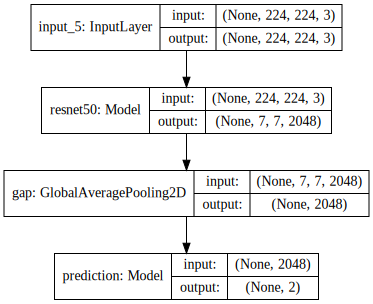

In [2]:
from keras.models import *
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model_clf = load_model('model_clf.h5')
SVG(model_to_dot(model_clf, show_shapes=True).create(prog='dot', format='svg'))

/Users/heweihua/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


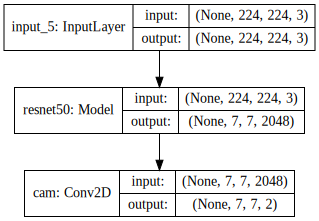

In [3]:
model_cam = load_model('model_cam.h5')
SVG(model_to_dot(model_cam, show_shapes=True).create(prog='dot', format='svg'))

#### 可视化测试
---
 利用刚才搭建的两个模型尝试可视化，首先用model_clf预测这张图片是猫还是狗。
 它会输出两个概率：第一个是猫的，第二个是狗的，我们取猫的概率，也就是prediction[0,0].
 然后用model_cam输出两张CAM可视化的图，模型输出的shape是（1，7，7，2），可以简单的用cam[0, :, :, 1 if prediction < 0.5 else 0]来提取对应类别的CAM图。
 之后我们进行一些调整，首先将图片缩小1/10, 因为CAM图的取值范围大概在-5~30，平均值大约是6，所以经过几次调整，除以10可视化效果比较好的数值，然后将数值限制在0~1之间。并转换为Uint8(因为接下来的染色需要Uint8的格式)。
 对CAM的染色使用Opencv的函数以及颜色条（见下图），我们选择了COLORMAP_JET样式。
 
 ![](http://docs.opencv.org/trunk/colorscale_jet.jpg)
 
 参考链接：http://docs.opencv.org/trunk/d3/d50/group__imgproc__colormap.html

 最后将染色的heatmap加载原图上，行形成最终的可视化效果图。

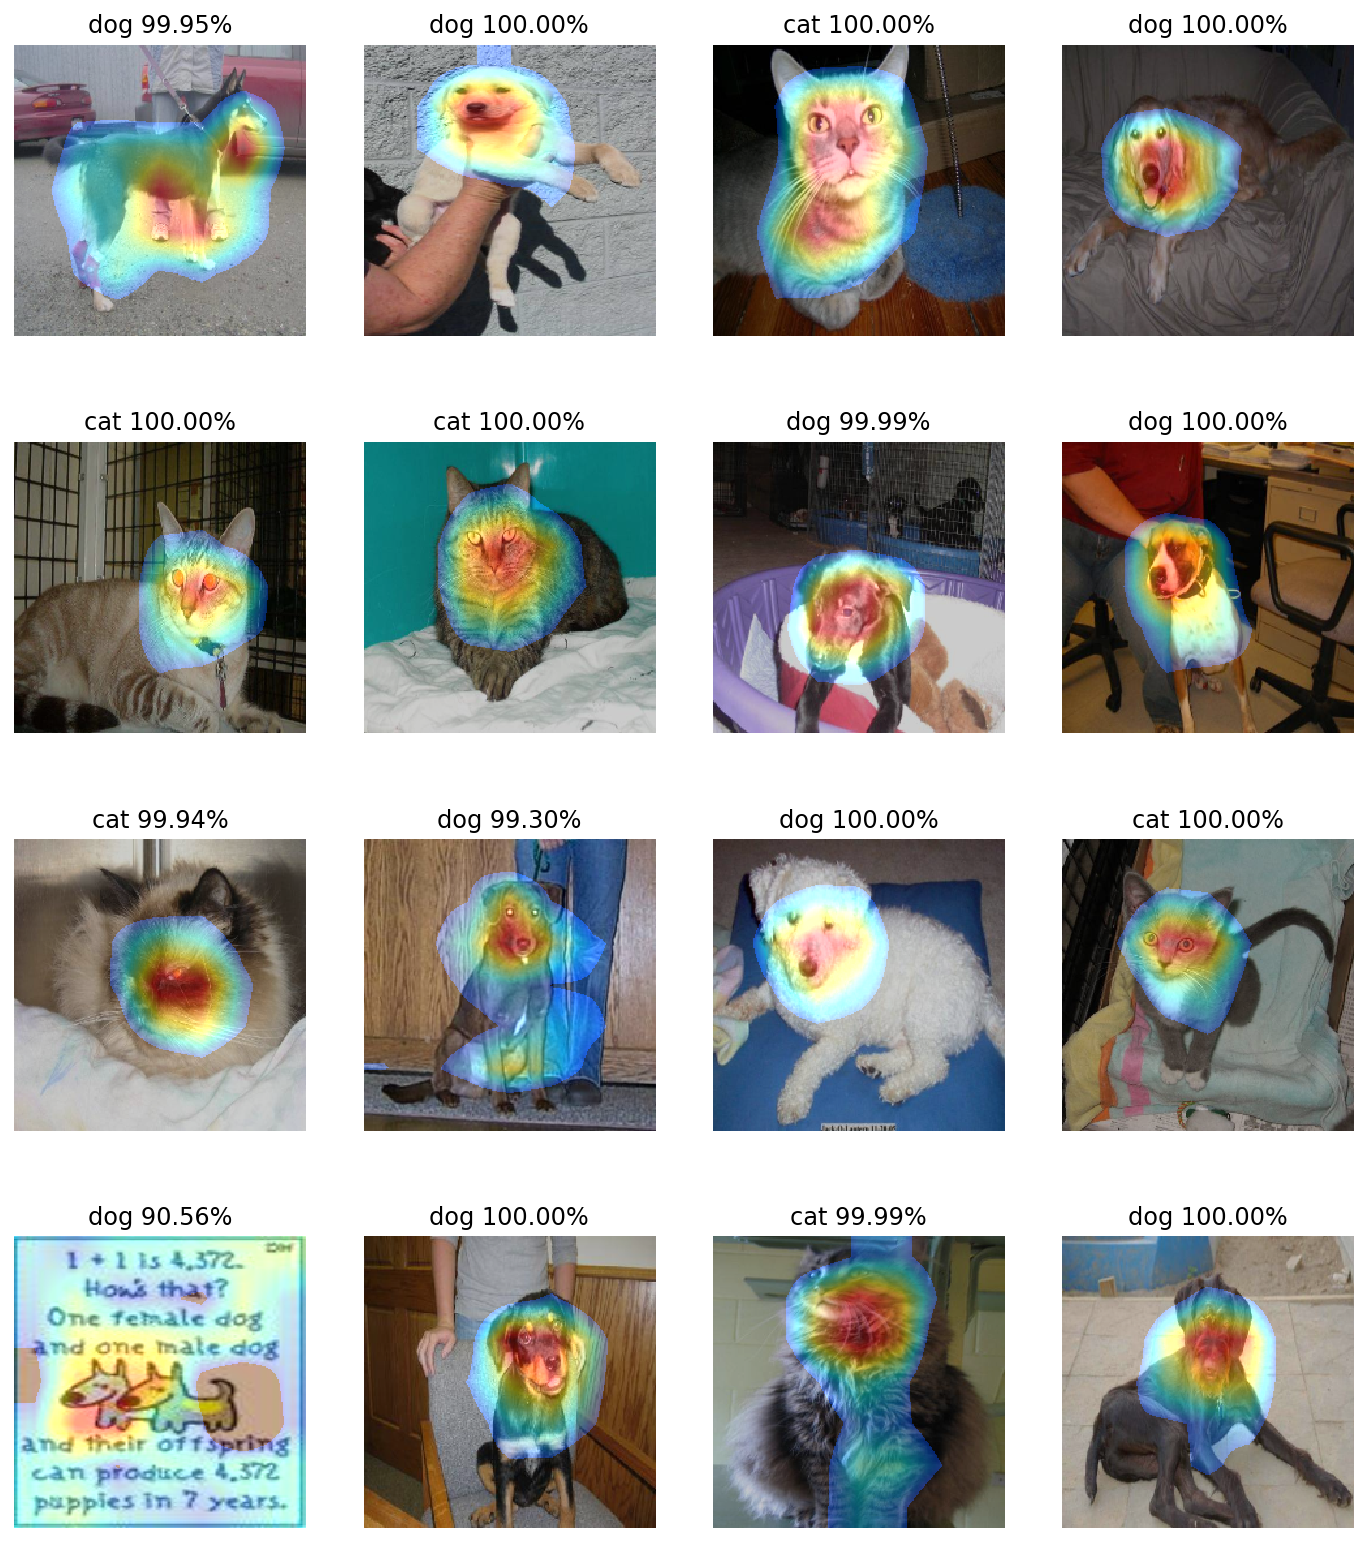

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 用模型进行预测
plt.figure(figsize=(12, 14))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = cv2.imread('image/test/%d.jpg' % random.randint(1, 12500))
    img = cv2.resize(img, (224, 224))
    x = img.copy()
    x.astype(np.uint8)

    prediction = model_clf.predict(np.expand_dims(img, 0))
#     print (prediction) #猫编码成【1，0】，狗编码成【0，1】 [9.408827e-10 1.000000e+00] = [0, 1] --> dog
    prediction = prediction[0, 0]
    if prediction < 0.5:
        plt.title('dog %.2f%%' % (100 - prediction*100))
    else:
        plt.title('cat %.2f%%' % (prediction*100))
    cam = model_cam.predict(np.expand_dims(img, 0))
#     print(cam.shape)
#     print(cam)
    cam = cam[0, :, :, 1 if prediction < 0.5 else 0]

    # 调整 CAM 的范围
    cam -= cam.min()
    cam /= cam.max()
    cam -= 0.2
    cam /= 0.8
    cam = cv2.resize(cam, (224, 224))

    # 染成彩色
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0

    # 加在原图上
    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

    # 显示图片
    plt.axis('off')
    plt.imshow(out[:,:,::-1])

导出mlmodel模型文件 在iOS11中，可以直接使用Keras模型，只需要使用苹果的模型转换库Core ML Tools将Keras以HDF5格式存储的模型转换为苹果使用的mlmodel格式即可。 参考链接：https://developer.apple.com/documentation/coreml/converting_trained_models_to_core_ml

In [10]:
from coremltools.converters.keras import convert
import coremltools

coreml_model = convert('model_clf.h5', blue_bias=103.939, green_bias=116.779, red_bias=123.68, 
                       input_names=['image'], image_input_names='image', output_names='prediction')
coreml_model.author = 'weihua.he'
coreml_model.short_description = 'Dogs vs Cats'
coreml_model.license = 'MIT' #指定许可证
coreml_model.input_description['image'] = 'A 224x224 Image.'
coreml_model.output_description['prediction'] = 'The probability of Dog and Cat.'
coreml_model.save('model_clf.mlmodel')

#CAM模型
coreml_model = convert('model_cam.h5', blue_bias=103.939, green_bias=116.779, red_bias=123.68, 
                       input_names=['image'], image_input_names='image', output_names='cam')
coreml_model.author = 'weihua.he'
coreml_model.short_description = 'Dogs vs Cats'
coreml_model.license = 'MIT'
coreml_model.input_description['image'] = 'A 224x224 Image.'
coreml_model.output_description['cam'] = 'The cam Image.'
coreml_model.save('model_cam.mlmodel')

ModuleNotFoundError: No module named 'coremltools'

将导出的模型，放到xcode新建的工程中使用即可, 摄像头识别使用的是opencv的摄像头。 iOS那部分代码由于篇幅问题且非重点，见github:https://github.com/bjheweihua/cats_vs_dogs

在iphone手机上运行App， 摄像头识别效果如下图：


<center class="half">
    <img src="source/ios_result.png" width="50%" height="50%"/>
</center>